# Business Problem

1. **Objective**
   - To classifiy an image into 3 categories: Driving License, Social Security Card, Other
   - Learn from images and its properties to classify into the respective categories better


2. **Machine Learning Problem**
   - Develop a machine learning model based on convolution neural network to learn properties of the 3 categories of images and predict accurately for new image


3. **Tech.**
   - Python, Scikit-learn, tensorflow, keras, Numpy
   

4. **Decision making**
   - Select the best model which performs the best w.r.t classification accuracy
   - Metrics: Accuracy
   

5. **Deployment**
   - Deploy model in a scalable way so that business decisions can be taken in near real time to classify images



**Dataset**<br>
driving_license images<br>
social_security images<br>
other images<br>

In [11]:
# Importing the libraries
import os
import numpy as np
from pathlib import Path
from zipfile import ZipFile
import PIL
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [12]:
folder = './Multi_class_image_classifier_CNN_TF.zip'
zipfile = ZipFile(folder)
zipfile.namelist()

['Multi_class_image_classifier_CNN_TF/Testing_Data/.DS_Store',
 'Multi_class_image_classifier_CNN_TF/Training_data/.DS_Store',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/13.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/46.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/32.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/9.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/3.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/47.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/40.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/44.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/20.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/45.jpg',
 'Multi_class_image_classifier_CNN_TF/Testing_Data/driving_license/4.jpg',
 'Multi_class_image_classifier_CNN_TF/Te

In [13]:
# Extract the contents of input directory
zipfile.extractall()

In [14]:
# Path object for training images
data_dir = Path("./Multi_class_image_classifier_CNN_TF/Training_data/")

In [15]:
# Total images count
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

600


In [16]:
driving_license = list(data_dir.glob('./driving_license/*'))
social_security = list(data_dir.glob('./social_security/*'))
others = list(data_dir.glob('./others/*'))

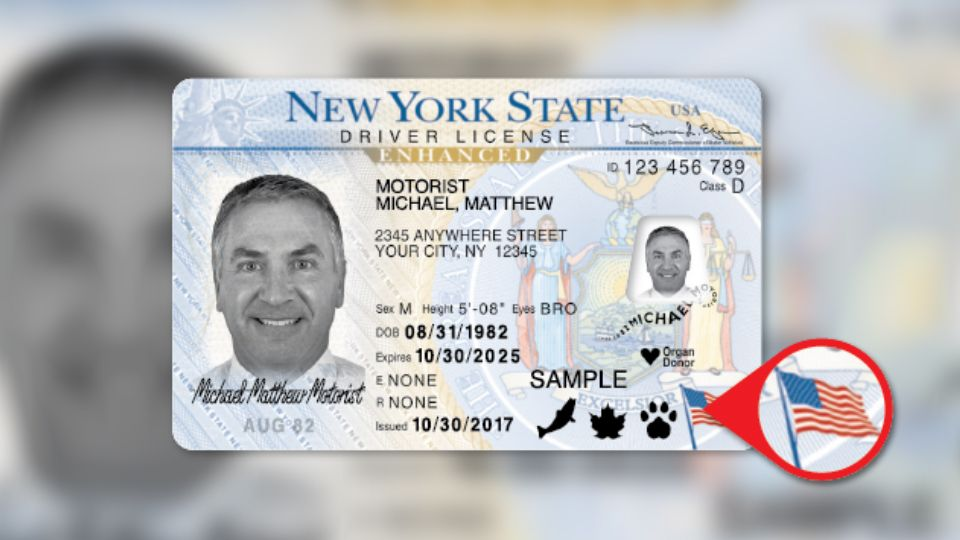

In [17]:
PIL.Image.open(str(driving_license[20]))

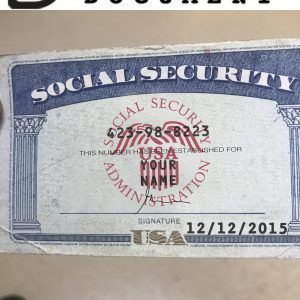

In [18]:
PIL.Image.open(str(social_security[10]))

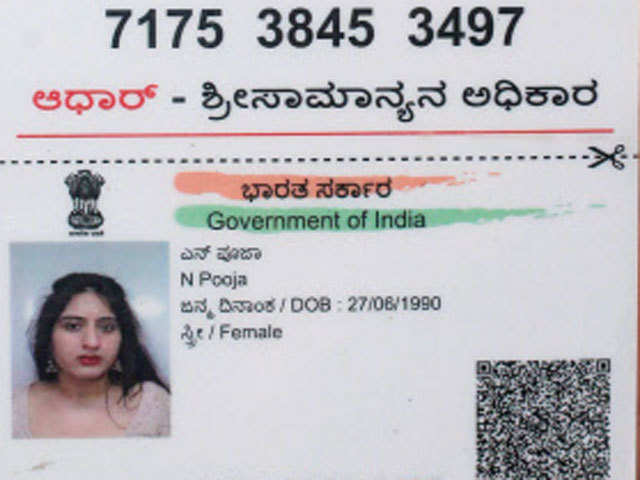

In [19]:
PIL.Image.open(str(others[25]))

In [20]:
# Image resolution for training
img_height, img_width = 180, 180

# Mini-batch size
batch_size = 32

In [21]:
# Preparing images for training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="training",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 600 files belonging to 3 classes.
Using 480 files for training.


In [22]:
# Preparing images for training dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=123,
            image_size=(img_height, img_width),
            batch_size=batch_size)

Found 600 files belonging to 3 classes.
Using 120 files for validation.


In [23]:
# Classes of images
class_names = train_ds.class_names
print(class_names)

['driving_license', 'others', 'social_security']


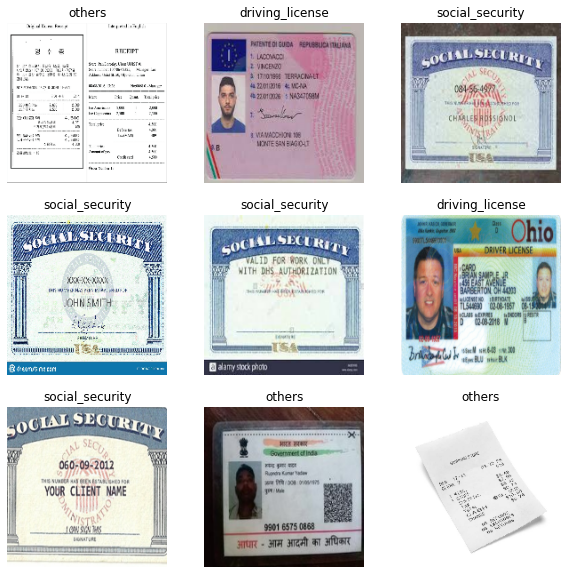

In [24]:
# first nine images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
# The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). 
#The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.
#You can call .numpy() on either of these tensors to convert them to a numpy.ndarray.
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print("--"*10)

(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------
(32, 180, 180, 3)
(32,)
--------------------


**Configure the dataset for performance**

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. 
These are two important methods we should use when loading data:

- Dataset.cache : 

> keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training our model.
If our dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache.

- Dataset.prefetch : 

> overlaps data preprocessing and model execution while training.

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Standardize the data**

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general we should seek to make our input values small.


Here, We will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling.

There are two ways to use this layer. 

- We can apply it to the dataset by calling Dataset.map  Or,

- We can include the layer inside your model definition to simplify deployment.

In [27]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0041666594 1.0


# CNN Model Building

In [29]:
num_classes = len(class_names)

# Defining the model architecture
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [30]:
# Compiling the model --> optimizer, loss function, evaluation metric
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [32]:
# Training the model 
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
15/15 [==============================] - 5s 313ms/step - loss: 1.2004 - accuracy: 0.4229 - val_loss: 0.9169 - val_accuracy: 0.5667
Epoch 2/20
15/15 [==============================] - 4s 291ms/step - loss: 0.5981 - accuracy: 0.7833 - val_loss: 0.3886 - val_accuracy: 0.8583
Epoch 3/20
15/15 [==============================] - 4s 289ms/step - loss: 0.3148 - accuracy: 0.8729 - val_loss: 0.3426 - val_accuracy: 0.8833
Epoch 4/20
15/15 [==============================] - 4s 294ms/step - loss: 0.2060 - accuracy: 0.9375 - val_loss: 0.6120 - val_accuracy: 0.7917
Epoch 5/20
15/15 [==============================] - 4s 289ms/step - loss: 0.1074 - accuracy: 0.9604 - val_loss: 0.2966 - val_accuracy: 0.8667
Epoch 6/20
15/15 [==============================] - 4s 289ms/step - loss: 0.0740 - accuracy: 0.9771 - val_loss: 0.2435 - val_accuracy: 0.9250
Epoch 7/20
15/15 [==============================] - 4s 291ms/step - loss: 0.0556 - accuracy: 0.9854 - val_loss: 0.2224 - val_accuracy: 0.9250
Epoch 

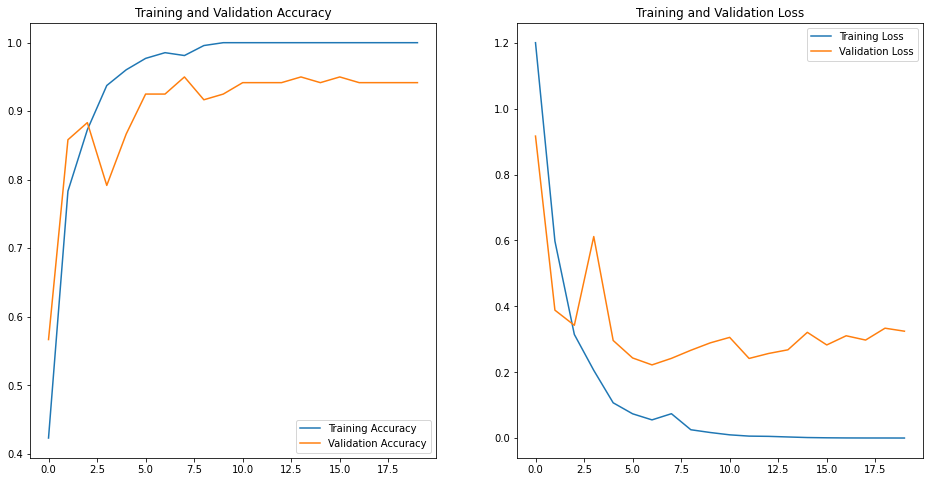

In [33]:
# Model validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Saving and Loading the model

In [34]:
# save the model
model.save("cnn-model.h5")

In [35]:
# Load the model
model = tf.keras.models.load_model("cnn-model.h5")

### Testing on unseen data (predictions)

In [36]:
test_data_dir = Path("./Multi_class_image_classifier_CNN_TF/Testing_Data/")

In [37]:
image_count = len(list(test_data_dir.glob('*/*')))
print(image_count)

150


In [38]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 3 classes.


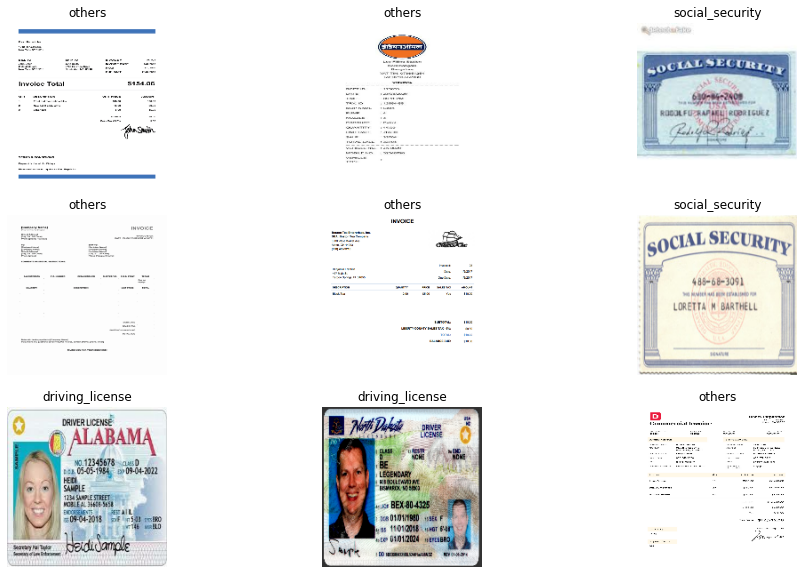

In [39]:
plt.figure(figsize=(16, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [40]:
# Performance on test data 
model.evaluate(test_ds)

5/5 [==============================] - 1s 59ms/step - loss: 0.3017 - accuracy: 0.9333


[0.30169710516929626, 0.9333333373069763]

In [41]:
# Function for prediction on an image
def get_prediction(img_array):
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    class_name = class_names[np.argmax(score)]
    confidence = 100*np.max(score)
    return class_name, confidence


img = tf.keras.utils.load_img(
    "./Multi_class_image_classifier_CNN_TF/Testing_Data/others/111.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

cat, conf = get_prediction(img_array)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(cat, conf)
)

This image most likely belongs to others with a 100.00 percent confidence.


# CNN Model with Data Augmentation:

Creating news images from the existing images by flipping, rotating, zooming etc. on them is Data Augmentation. 

For better model training, We do Data augmentation when we don't have sufficient images for training.

In [42]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

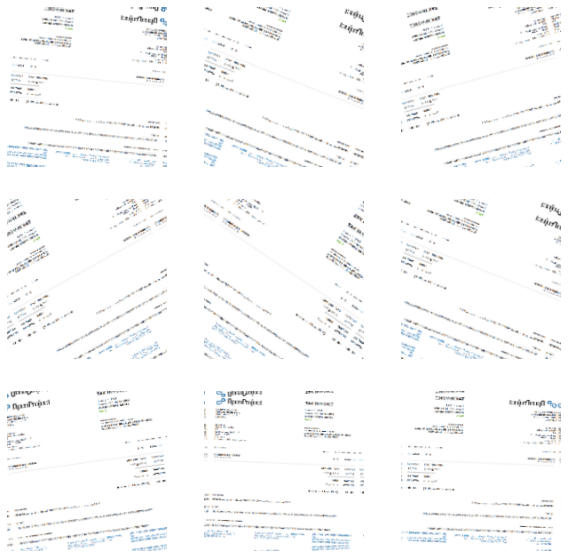

In [43]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [44]:
# Model architecture with layers for Data Augmentatio
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [47]:
# Training the model 
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
15/15 [==============================] - 6s 338ms/step - loss: 1.6375 - accuracy: 0.3562 - val_loss: 1.0807 - val_accuracy: 0.3917
Epoch 2/30
15/15 [==============================] - 5s 326ms/step - loss: 1.0365 - accuracy: 0.4688 - val_loss: 0.9924 - val_accuracy: 0.3667
Epoch 3/30
15/15 [==============================] - 5s 321ms/step - loss: 0.7808 - accuracy: 0.6750 - val_loss: 0.7374 - val_accuracy: 0.6750
Epoch 4/30
15/15 [==============================] - 5s 323ms/step - loss: 0.6014 - accuracy: 0.7604 - val_loss: 0.7460 - val_accuracy: 0.6250
Epoch 5/30
15/15 [==============================] - 5s 324ms/step - loss: 0.5494 - accuracy: 0.7958 - val_loss: 0.6260 - val_accuracy: 0.7750
Epoch 6/30
15/15 [==============================] - 5s 323ms/step - loss: 0.4382 - accuracy: 0.8292 - val_loss: 0.4166 - val_accuracy: 0.8667
Epoch 7/30
15/15 [==============================] - 5s 326ms/step - loss: 0.4870 - accuracy: 0.8062 - val_loss: 0.4337 - val_accuracy: 0.8417
Epoch 

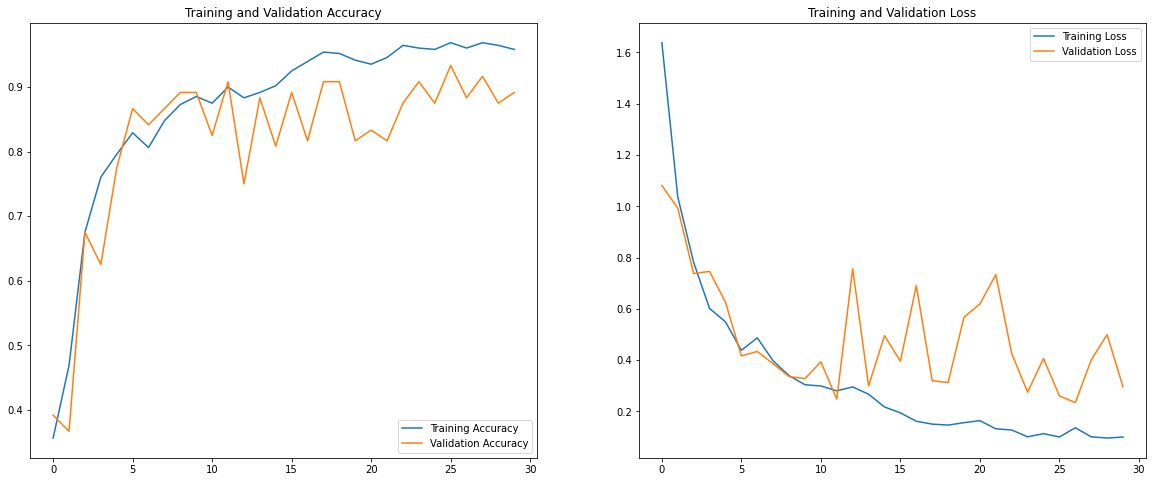

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Saving and Loading the model

In [49]:
# Save the model
model.save("cnn-model_with_augmentation.h5")

In [50]:
# Load the model for predictions
model = tf.keras.models.load_model("cnn-model_with_augmentation.h5")

### Testing on unseen data (predictions)

In [51]:
test_data_dir = Path("./Multi_class_image_classifier_CNN_TF/Testing_Data/")

In [52]:
image_count = len(list(test_data_dir.glob('*/*')))
print(image_count)

150


In [53]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 3 classes.


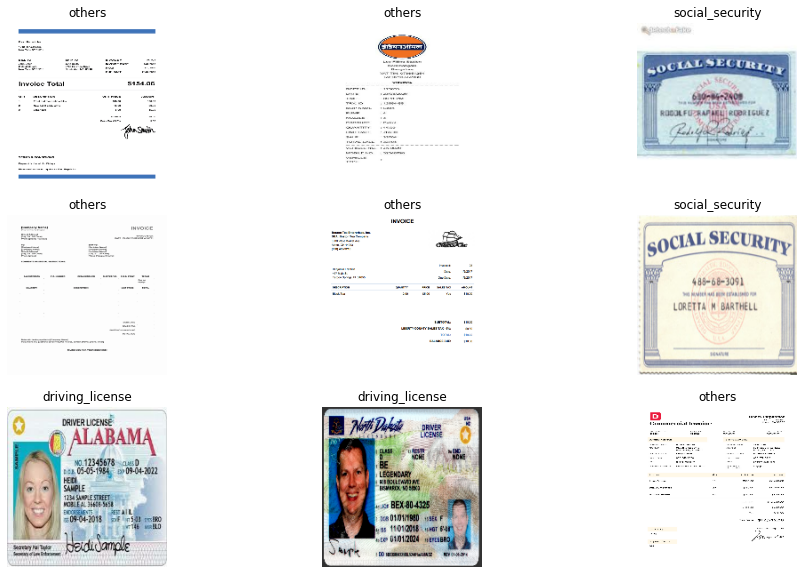

In [54]:
plt.figure(figsize=(16, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [55]:
# Performance on test data 
model.evaluate(test_ds)

5/5 [==============================] - 1s 52ms/step - loss: 0.3202 - accuracy: 0.9000


[0.3202168643474579, 0.8999999761581421]

In [56]:
# Function for prediction on an image
def get_prediction(img_array):
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    class_name = class_names[np.argmax(score)]
    confidence = 100*np.max(score)
    return class_name, confidence


img = tf.keras.utils.load_img(
    "./Multi_class_image_classifier_CNN_TF/Testing_Data/others/135.jpg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

cat, conf = get_prediction(img_array)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence.".format(cat, conf)
)

This image most likely belongs to others with a 98.80 percent confidence.


In [59]:
test_driving_license = list(test_data_dir.glob('driving_license/*'))
test_social_security = list(test_data_dir.glob('social_security/*'))
test_others = list(test_data_dir.glob('others/*'))

1. Multi_class_image_classifier_CNN_TF\Testing_Data\driving_license\44.jpg


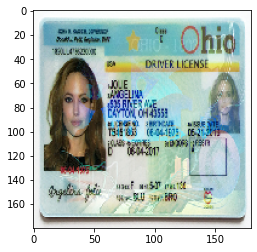

This image most likely belongs to driving_license with a 97.51 percent confidence. 


2. Multi_class_image_classifier_CNN_TF\Testing_Data\driving_license\14.jpg


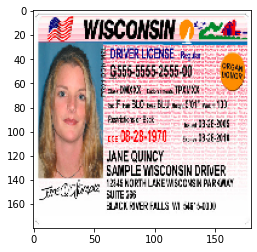

This image most likely belongs to driving_license with a 99.73 percent confidence. 


3. Multi_class_image_classifier_CNN_TF\Testing_Data\driving_license\17.jpg


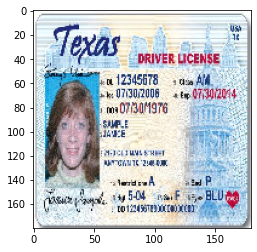

This image most likely belongs to driving_license with a 99.85 percent confidence. 


4. Multi_class_image_classifier_CNN_TF\Testing_Data\social_security\93.jpg


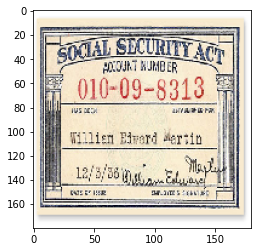

This image most likely belongs to others with a 77.89 percent confidence. 


5. Multi_class_image_classifier_CNN_TF\Testing_Data\social_security\89.jpg


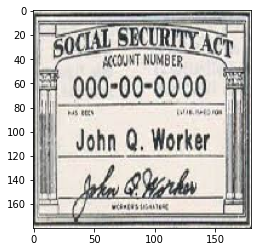

This image most likely belongs to social_security with a 83.98 percent confidence. 


6. Multi_class_image_classifier_CNN_TF\Testing_Data\social_security\56.jpg


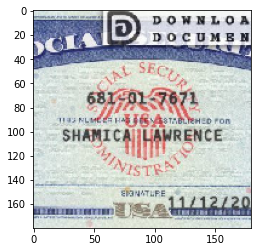

This image most likely belongs to social_security with a 99.90 percent confidence. 


7. Multi_class_image_classifier_CNN_TF\Testing_Data\others\124.png


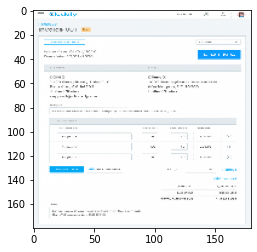

This image most likely belongs to others with a 99.19 percent confidence. 


8. Multi_class_image_classifier_CNN_TF\Testing_Data\others\124.png


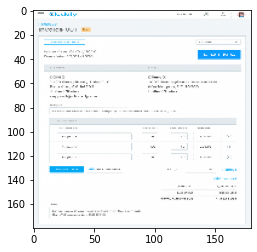

This image most likely belongs to others with a 99.19 percent confidence. 


9. Multi_class_image_classifier_CNN_TF\Testing_Data\others\136.png


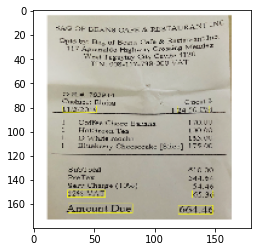

This image most likely belongs to others with a 95.15 percent confidence. 




In [71]:
import random

classes_test = [test_driving_license, test_social_security, test_others]

img_num = 1
for files in classes_test:
    for img_file in random.choices(files, k=3):
        print(f"{img_num}. {img_file}")
        img = tf.keras.utils.load_img(
            img_file, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        plt.imshow(img_array.astype("uint8"))
        plt.show()
        actual = str(img_file).split("\\")[-2]
        pred, conf = get_prediction(tf.expand_dims(img_array, 0))
        print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(pred, conf),"\n\n")
        img_num += 1 